In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/WTI原油期货价格拟合残差_WTI连1-连4.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['WTI原油期货价格拟合残差/WTI连1-连4月差'].last_valid_index() 
sheet['去库幅度平均价'] = sheet[['EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年', '全球石油去库幅度/EIA月报调整/3MMA超季节性/3年']].mean(axis=1)

In [5]:
def transform_axis_scale(data, original_min, original_max, target_min, target_max):
    # Calculate ranges
    original_range = original_max - original_min
    target_range = target_max - target_min
    # Normalize data to 0-1 range
    normalized_data = (data - original_min) / original_range
    # Map normalized data to new range
    transformed_data = normalized_data * target_range + target_min
    return transformed_data

# Example usage
sheet['去库幅度平均价_转换'] = transform_axis_scale(sheet['去库幅度平均价'],original_min=-2,original_max=2, target_min=-30,target_max=5)



In [6]:
sheet

,WTI原油期货价格拟合残差/WTI连1-连4月差,EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年,全球石油去库幅度/EIA月报调整/3MMA超季节性/3年,去库幅度平均价,去库幅度平均价_转换
Date,,,,,
1995-01-31,NaN,0.5931,0.5931,0.59310,-7.310375
1995-02-28,NaN,0.3794,0.3794,0.37940,-9.180250
1995-03-31,NaN,0.3578,0.3578,0.35780,-9.369250
1995-04-30,NaN,-0.2153,-0.2153,-0.21530,-14.383875
1995-05-31,NaN,-0.2214,-0.2214,-0.22140,-14.437250
...,...,...,...,...,...
2026-08-31,NaN,-0.4719,-1.0939,-0.78290,-19.350375
2026-09-30,NaN,-0.5085,-1.0693,-0.78890,-19.402875
2026-10-31,NaN,-0.5636,-1.0658,-0.81470,-19.628625


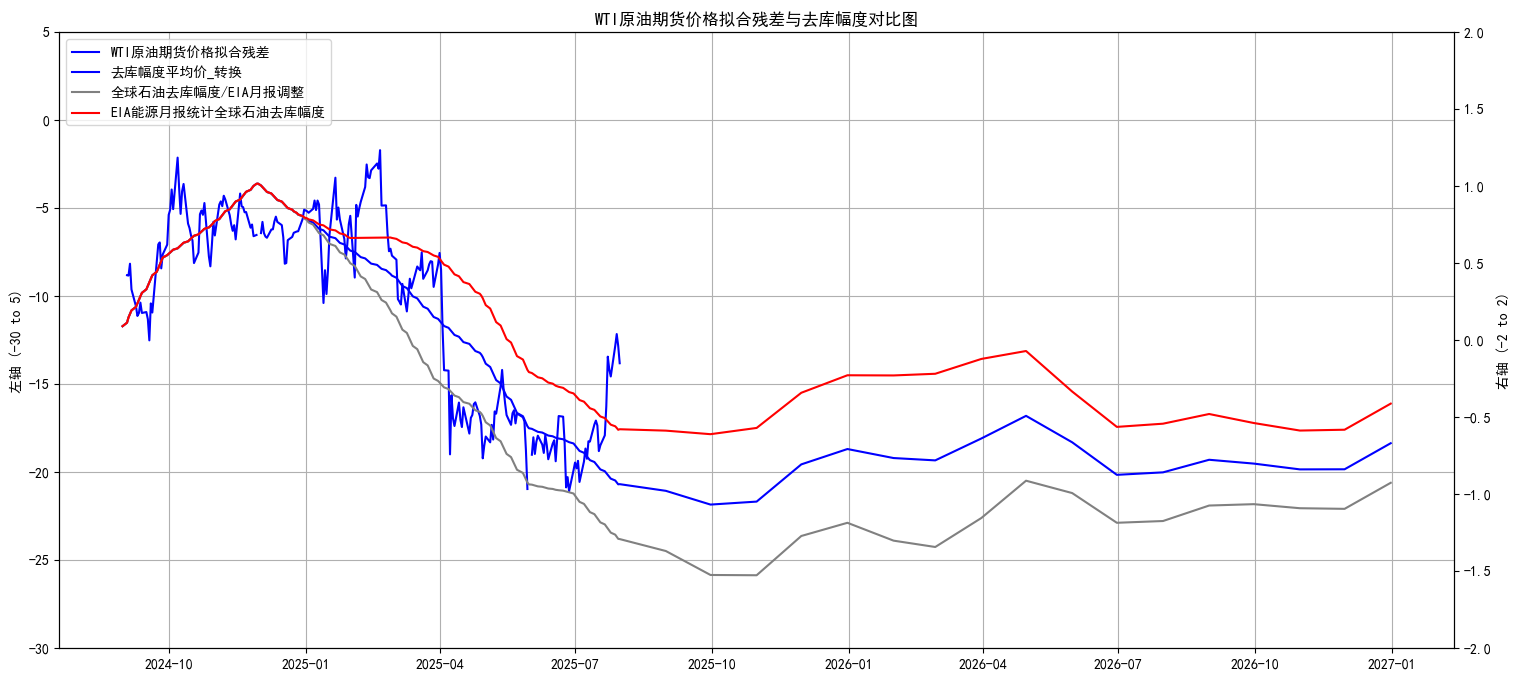

In [7]:

# 选取2024/8/30之后的数据
data = sheet[sheet.index > '2024-08-30']

# 获取除了'WTI原油期货价格拟合残差/WTI连1-连4月差'之外的所有列
columns_to_fill = [col for col in data.columns if col != 'WTI原油期货价格拟合残差/WTI连1-连4月差']
# 对选定的列进行线性插值填充,只填充到last_day
for col in columns_to_fill:
    data.loc[data.index <= last_day, col] = data.loc[data.index <= last_day, col].interpolate(method='linear')

# 创建图形和两个y轴
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()

# 设置左轴范围和标签
ax1.set_ylim(-30, 5)
ax1.set_ylabel('左轴 (-30 to 5)', color='black')

# 设置右轴范围和标签 
ax2.set_ylim(-2, 2)
ax2.set_ylabel('右轴 (-2 to 2)', color='black')

# 使用scipy的savgol_filter进行平滑处理
from scipy.signal import savgol_filter

# 对数据进行平滑处理
window = 4  # 窗口大小
order = 3   # 多项式阶数

# 绘制左轴数据
ax1.plot(data.index, data['WTI原油期货价格拟合残差/WTI连1-连4月差'], label='WTI原油期货价格拟合残差', color='blue')

# 对其他数据进行平滑处理
quku_smooth = savgol_filter(data['去库幅度平均价_转换'], window, order)
ax1.plot(data.index, quku_smooth, label='去库幅度平均价_转换', color='blue')

# 绘制右轴数据
quanqiu_smooth = savgol_filter(data['全球石油去库幅度/EIA月报调整/3MMA超季节性/3年'], window, order)
eia_smooth = savgol_filter(data['EIA能源月报统计全球石油去库幅度/3MMA超季节性/3年'], window, order)
ax2.plot(data.index, quanqiu_smooth, label='全球石油去库幅度/EIA月报调整', color='gray')
ax2.plot(data.index, eia_smooth, label='EIA能源月报统计全球石油去库幅度', color='red')

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 设置标题和网格
plt.title('WTI原油期货价格拟合残差与去库幅度对比图')
ax1.grid(True)

plt.show()


In [8]:
# 选取需要的列
cols = ['WTI原油期货价格拟合残差/WTI连1-连4月差', '去库幅度平均价_转换']
sheet_daily = sheet[cols]

# 设定时间范围
start_date = '2024-08-01'
last_day_month_end = pd.Timestamp(last_day).to_period('M').to_timestamp('M')
end_date = last_day_month_end + pd.DateOffset(months=3)

# 筛选时间范围内的数据
sheet_daily = sheet_daily[start_date:end_date]

# 处理去库幅度平均价数据
mask_month = (sheet_daily.index.year == last_day_month_end.year) & (sheet_daily.index.month == last_day_month_end.month)
mask_before = sheet_daily.index <= last_day
sheet_daily.loc[mask_month | mask_before, '去库幅度平均价_转换'] = np.nan

# 删除全为空的行
sheet_daily = sheet_daily.dropna(how='all', subset=cols)
sheet_daily.tail()

,WTI原油期货价格拟合残差/WTI连1-连4月差,去库幅度平均价_转换
Date,,
2025-07-30,-12.8220,NaN
2025-07-31,-13.8051,NaN
2025-08-31,NaN,-20.704438
2025-09-30,NaN,-21.470063
2025-10-31,NaN,-21.978437


In [9]:
merged_df_daily = sheet_daily.copy()
merged_df_daily = merged_df_daily.reset_index()

rolling_mean_daily = merged_df_daily['去库幅度平均价_转换'].rolling(window=3, min_periods=3).mean()
last_date = merged_df_daily.index[-1]
merged_df_daily.loc[:,'去库幅度平均价_转换'] = np.nan
merged_df_daily.loc[last_date,'去库幅度平均价_转换'] = rolling_mean_daily.iloc[-1]
merged_df_daily = merged_df_daily.dropna(how='all', subset=['WTI原油期货价格拟合残差/WTI连1-连4月差', '去库幅度平均价_转换'])

merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/WTI原油期货价格拟合残差_WTI连1-连4月差2_合并数据.xlsx', index=False,float_format='%.4f')
merged_df_daily.head()

,Date,WTI原油期货价格拟合残差/WTI连1-连4月差,去库幅度平均价_转换
254,2025/10/31,NaN,-21.384313
251,2025/07/31,-13.8051,NaN
250,2025/07/30,-12.8220,NaN
249,2025/07/29,-12.1464,NaN
248,2025/07/28,-12.8201,NaN


In [10]:
merged_df_monthly = sheet_daily.copy()
merged_df_monthly = merged_df_monthly.resample('ME').last()

rolling_mean = merged_df_monthly['去库幅度平均价_转换'].rolling(window=3, min_periods=3).mean()
last_date = merged_df_monthly.index[-1]
merged_df_monthly.loc[:,'去库幅度平均价_转换'] = np.nan
merged_df_monthly.loc[last_date,'去库幅度平均价_转换'] = rolling_mean.iloc[-1]
merged_df_monthly = merged_df_monthly.dropna(how='all', subset=['WTI原油期货价格拟合残差/WTI连1-连4月差', '去库幅度平均价_转换'])

merged_df_monthly = merged_df_monthly.reset_index()
merged_df_monthly = merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/WTI原油期货价格拟合残差_WTI连1-连4月差2_月度数据.xlsx', index=False,float_format='%.4f')
merged_df_monthly.head()

,Date,WTI原油期货价格拟合残差/WTI连1-连4月差,去库幅度平均价_转换
12,2025/10/31,NaN,-21.384313
11,2025/07/31,-13.8051,NaN
10,2025/06/30,-19.8777,NaN
9,2025/05/31,-20.9515,NaN
8,2025/04/30,-19.2074,NaN


In [11]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.原油季度_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "WTI原油期货价格拟合残差/WTI连1-连4月差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

更新数据时出错: [Errno 13] Permission denied: 'eta/1.原油季度_数据上传.xlsx'
数据更新失败，请检查错误信息


In [12]:
from Lcel import update_excel_data
file_path = "eta/1.原油季度_数据上传.xlsx"
sheet_name = "详情页"
identifier = "WTI原油期货价格拟合残差/WTI连1-连4月差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


input_data 中缺少受保护日期行 2025/08/31
数据更新失败，请检查错误信息
